Stable Diffusion
================

El modelo o arquitectura de "Stable Diffusion" fue introducido en el paper [High-Resolution Image Synthesis with Latent Diffusion Models (2022)](https://arxiv.org/pdf/2112.10752.pdf), el cual introdujo el concepto de «Latent Diffusion Models». Su eficiencia computacional hizo que la técnica de difusores pudiera resultar práctica para la generación de imágenes de alta calidad.

En este ejemplo, veremos como utilizar este modelo junto a la libraria `diffusers` de HuggingFace.


## Preparación del ambiente

Necesitaremos las siguientes librerias:

In [ ]:
%pip install transformers diffusers accelerate --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 90.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.5 MB/s eta 0:00:00


## Utilizando el modelo de Stable Diffusion 1.4

Los modelos basados en Stable Diffusion están compuestos por 4 elementos, 3 de los cuales son modelos pre-entrenados:
- Encoder
- UNet model
- Scheduler

Descargaremos todos estos modelos desde el mismo repositorio de HuggingFace. **CompVis** es un grupo de investigación de Visión y aprendizaje por computadora de la universidad de Ludwig Maximilian en Munich.

In [ ]:
model_name = "CompVis/stable-diffusion-v1-4"

Estos modelos suelen requirer ejecutarse sobre una GPU (cuda):

In [ ]:
device = "cuda"

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from diffusers import UniPCMultistepScheduler
import torch

El primer modelo que cargaremos será nuestro codificador de texto, junto a su respectivo tokenizer:

In [ ]:
tokenizer = CLIPTokenizer.from_pretrained(model_name, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_name, subfolder="text_encoder")

El segundo y tercer modelo que cargaremos será nuestro codificador de imagenes y nuestra red UNet, de igual forma que vimos en ejemplos anteriores para difusores.

In [ ]:
image_encoder = AutoencoderKL.from_pretrained(model_name, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet")

Finalmente, necesitamos de un planificador para que guíe todo el proceso de difusión:

In [ ]:
scheduler = UniPCMultistepScheduler.from_pretrained(model_name, subfolder="scheduler")

Movamos los modelos a la GPU:

In [ ]:
text_encoder = text_encoder.to(device)
image_encoder = image_encoder.to(device)
unet = unet.to(device)

El siguiente paso es utilizar el tokenizer para generar embeddings del texto (el cual se conoce como *prompt*). Este texto lo usaremos para condicionar el modelo UNet y dirigir el proceso de difusión hacia algo que se asemeje a entrada indicada.

In [ ]:
prompt = ["a photograph of an child riding a butterfly over the sea"]
batch_size = len(prompt)

In [ ]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

In [ ]:
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

Generamos otra entrada de texto, pero en este caso, no condicionada por el texto que introducimos. En tal caso, simplemente serán tokens vacios:

In [ ]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

El texto final es vector que representa 2 embeddings: la primera parte es un texto que no condicionará la generación, mientras que la segunda si lo hará:

In [ ]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

Definimos algunos hiper-parámetros de la generación:

In [ ]:
height = 512  # altura de la imagen por defecto en Stable Diffusion
width = 512  # ancho de la imagen por defecto en Stable Diffusion
num_inference_steps = 75  # Numero de pasos de denoising.
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.manual_seed(42)  # Semilla para la generación de números.

Generamos nuestra imagen incial inicializada con ruido aleatorio:

In [ ]:
latents = torch.randn(
    (batch_size, unet.config.in_channels, height, width), generator=generator,
)
latents = latents.to(device)

Comenzamos el proceso de denosing:

In [ ]:
latents = latents * scheduler.init_noise_sigma

In [ ]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/75 [00:00<?, ?it/s]

In [ ]:
noise_pred.shape

torch.Size([1, 4, 64, 64])

In [ ]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = image_encoder.decode(latents).sample

In [ ]:
def image_from_output(denoised_image):
  from PIL import Image

  image = ((denoised_image / 2 + 0.5).clamp(0, 1) * 255).round().type(torch.uint8)
  image = image.cpu().permute(0,2,3,1)
  image = image.numpy()[0]

  return Image.fromarray(image)

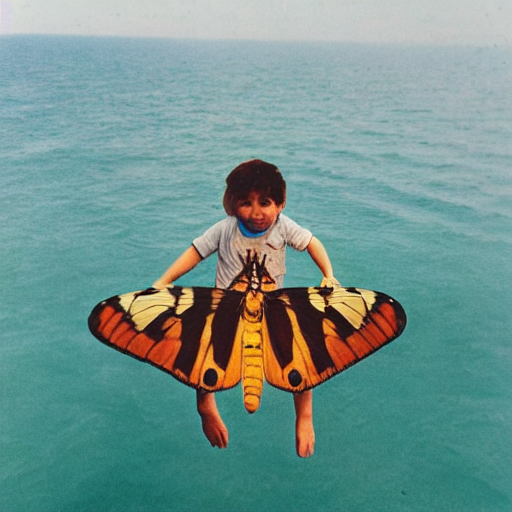

In [ ]:
image_from_output(image)

## Utilizando un pipeline

Hasta aquí hemos implementado el proceso de difusión manualmente para que tenga en cuenta como funciona internamente. Sin embargo, este procedimiento ya se encuentra implementado en un pipeline en HuggingFace dentro de la libraría `diffusers`:

### Utilizando un pipeline preconfigurado

Adicionalmente, podemos utilizar un pipeline de la libraría `diffusers` que ya esté configurado. Esto lo realizamos indicando simplemente el nombre del repositorio de HuggingFace que queremos utilizar. Este mecanismo es el mismo que hemos utilizado multiples veces en texto con `transformers`.

In [ ]:
from diffusers import StableDiffusionPipeline

stable_diffusion_txt2img = StableDiffusionPipeline.from_pretrained(model_name)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


#### Cambiando alguno de los componentes del pipeline

Si bien el pipeline esta preconfigurado con todos los componentes necesarios para utilizarlo, podemos inspeccionar que componentes está utilizando:

In [ ]:
print("Componentes en el pipeline:")
for key, value in stable_diffusion_txt2img.components.items():
  print(f" - Componente {key} del tipo {type(value).__name__}")

Componentes en el pipeline:
 - Componente vae del tipo AutoencoderKL
 - Componente text_encoder del tipo CLIPTextModel
 - Componente tokenizer del tipo CLIPTokenizer
 - Componente unet del tipo UNet2DConditionModel
 - Componente scheduler del tipo UniPCMultistepScheduler
 - Componente safety_checker del tipo NoneType
 - Componente feature_extractor del tipo NoneType


Podemos cambiar, por ejemplo, el scheduler utilizado:

In [ ]:
from diffusers import DPMSolverMultistepScheduler

stable_diffusion_txt2img.scheduler = DPMSolverMultistepScheduler.from_config(stable_diffusion_txt2img.scheduler.config)

> Notar que estamos cambiando el tipo del programador, pero utilizamos la misma configuración que el programador anterior (`stable_diffusion_txt2img.scheduler.config`).

  0%|          | 0/100 [00:00<?, ?it/s]

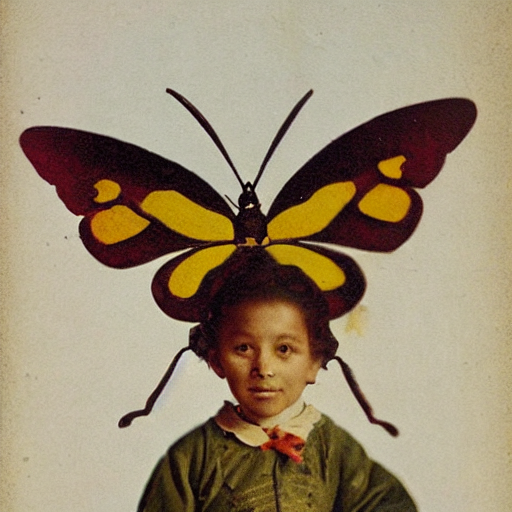

In [ ]:
stable_diffusion_txt2img(prompt=prompt, generator=generator, num_inference_steps=100).images[0]

### Indicando cada uno de los componentes

Podemos inicializar el pipeline indicando cada uno de los componentes del mismo:

In [ ]:
from diffusers import StableDiffusionPipeline

stable_diffusion_txt2img = StableDiffusionPipeline(
    vae=image_encoder,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    scheduler=scheduler,
    safety_checker=None,
    feature_extractor=None,
)

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Podemos ejecutar el proceso de inferencia como sigue:

  0%|          | 0/100 [00:00<?, ?it/s]

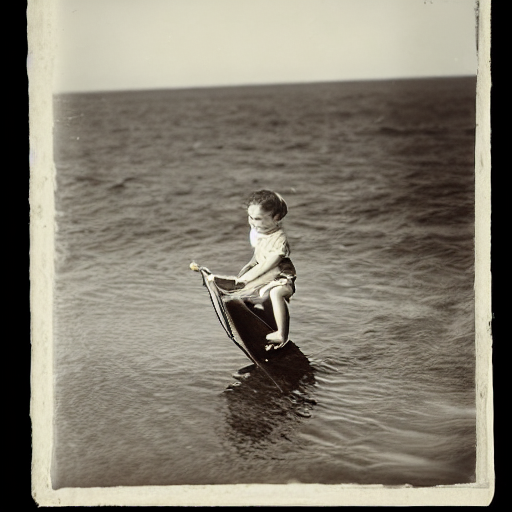

In [ ]:
stable_diffusion_txt2img(prompt=prompt, num_inference_steps=100).images[0]

Muchas veces es importante poder reproducir los resultados, para realizarlo, puede configurar una semilla en particular:

  0%|          | 0/100 [00:00<?, ?it/s]

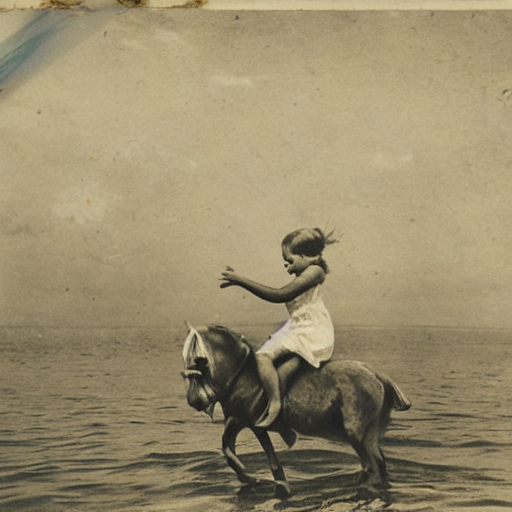

In [ ]:
generator = torch.Generator(device="cuda").manual_seed(8)
stable_diffusion_txt2img(prompt=prompt, generator=generator, num_inference_steps=100).images[0]

### Verificación del contenido

Los modelos basados en diffusion pueden generar contenido definido como dañino. Para esto, la librería diffusers implementa la "safety checkers" que le permiten verificar si una imagen generada no cumple con determinados códigos de conducta. El método `from_pretrained` puede recibir el parámetro `safety_checker` que permite configurar esto.